In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook"])

## Data intake

In [50]:
ceda = pd.read_pickle("CEDA_dataNL.pickle")
openmeteo = pd.read_pickle("Data/openmeteo.pickle")
pvgis = pd.read_pickle('Data/PVGIS.pickle')

prod_NL = pd.read_pickle("Data/NL_power.pickle")
meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation": "downward_surface_SW_flux",
              "diffuse_radiation":"diffuse_surface_SW_flux",
              "direct_normal_irradiance":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)
variates = list(ceda.columns)
rows = int(np.ceil(np.sqrt(len(variates))))

## Historic plot

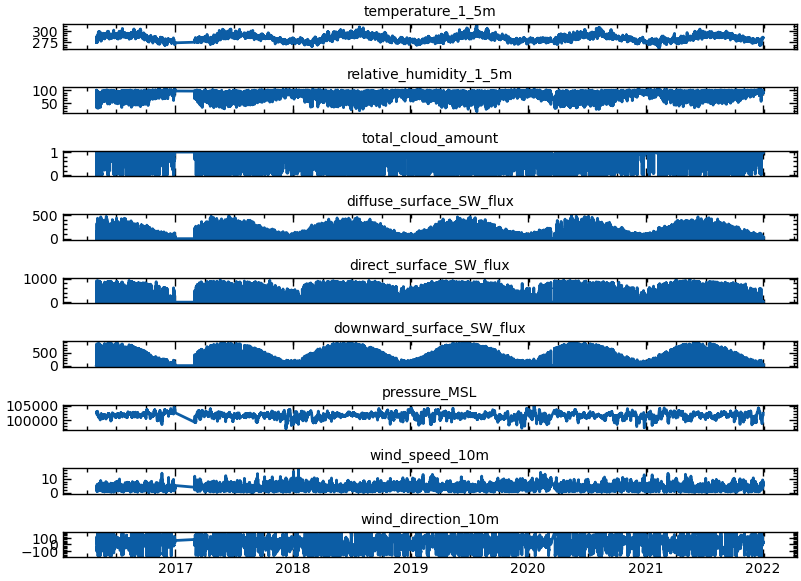

In [19]:
fig, axs = plt.subplots(len(variates), sharex=True)
plt.tight_layout()
for i, var in enumerate(variates):
    axs[i].plot(ceda[var])
    axs[i].set_title(var, fontsize = 10)
    axs[i].tick_params(labelsize=10)
plt.show()


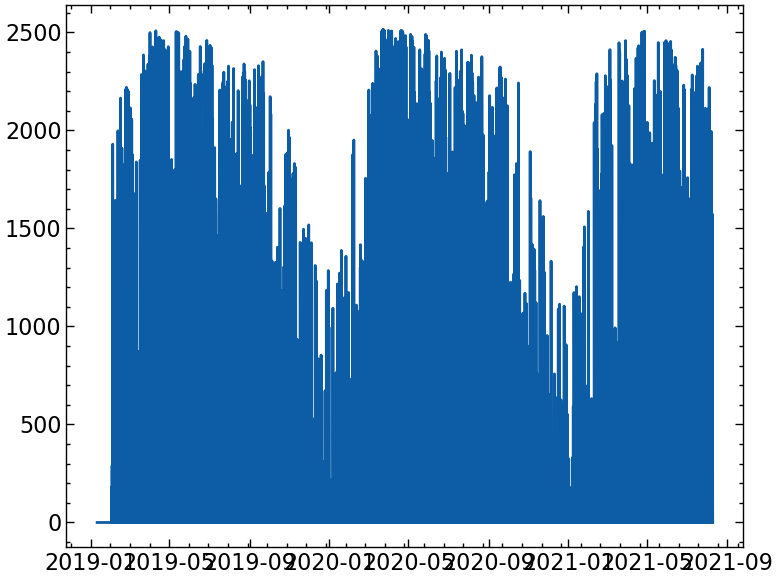

In [22]:
plt.plot(prod_NL)
plt.tight_layout()

## Histograms

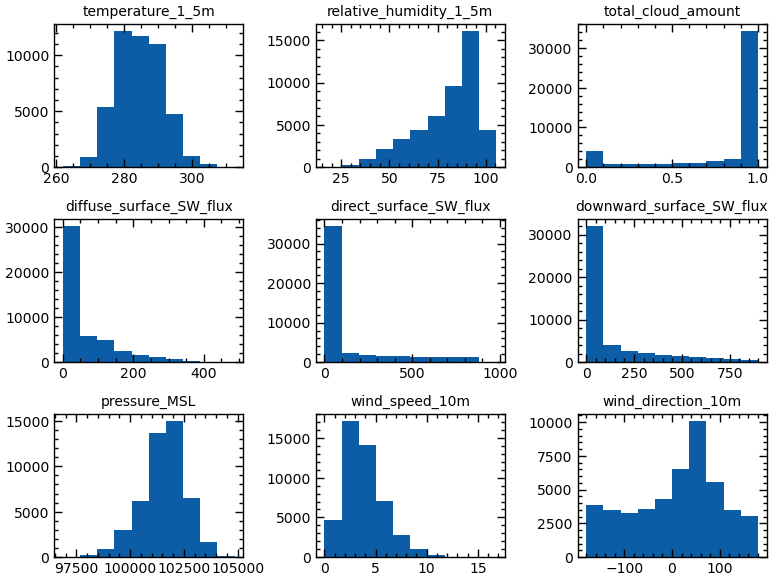

In [23]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## Correlation: CEDA & PROD_NL 

Here add still correlation with transformed variables


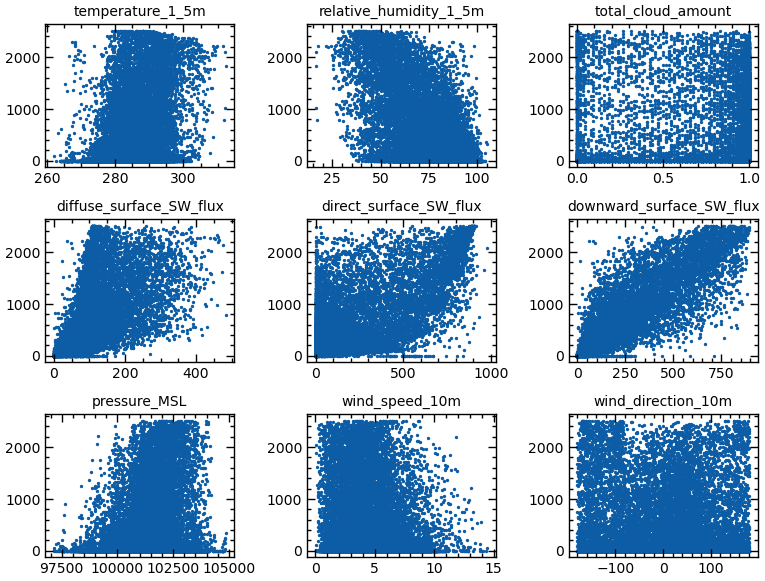

In [39]:
correl = pd.merge(prod_NL, ceda, right_index=True, left_index=True)
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter( correl[var],correl ['P'],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

C:\Users\Robbe\AppData\Local\Temp\ipykernel_6296\2909738593.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


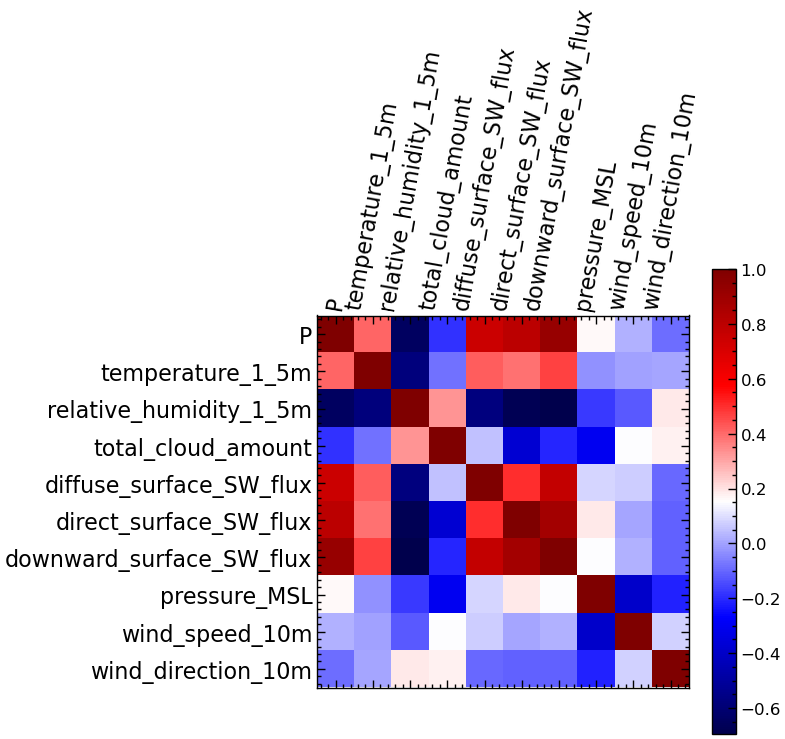

In [35]:
axs = plt.matshow(correl.corr(), cmap='seismic')
plt.xticks(ticks=range(10), labels=list(correl.columns), rotation= 80)
plt.yticks(ticks=range(10), labels = list(correl.columns), rotation= 0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## CEDA VS OPENMETEO

In [47]:
openmeteo = openmeteo.reindex(ceda.index)

,temperature_1_5m,relative_humidity_1_5m,pressure_MSL,total_cloud_amount,wind_speed_10m,wind_direction_10m,downward_surface_SW_flux,diffuse_surface_SW_flux,direct_surface_SW_flux
2016-05-01 00:00:00+00:00,276.830505,89.285660,1025.300049,0.000,3.101613,358.152435,0.0,0.0,0.000000
2016-05-01 01:00:00+00:00,276.330505,90.854256,1025.800049,0.000,2.507987,4.573841,0.0,0.0,0.000000
2016-05-01 02:00:00+00:00,275.980499,91.482162,1026.199951,0.021,2.800000,360.000000,0.0,0.0,0.000000
2016-05-01 03:00:00+00:00,275.780487,91.797310,1026.199951,0.102,3.301515,1.735665,0.0,0.0,0.000000
2016-05-01 04:00:00+00:00,275.730499,91.794098,1026.599976,0.180,2.630589,8.746089,21.0,12.0,97.652107
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,284.830505,93.275887,1019.500000,0.459,5.693857,239.381470,0.0,0.0,0.000000
2021-12-31 20:00:00+00:00,284.580505,95.145828,1020.400024,1.000,6.307139,244.653870,0.0,0.0,0.000000
2021-12-31 21:00:00+00:00,284.880493,94.213600,1021.200012,1.000,6.293648,252.428650,0.0,0.0,0.000000
2021-12-31 22:00:00+00:00,284.830505,94.211380,1021.599976,0.876,5.478138,248.586960,0.0,0.0,0.000000


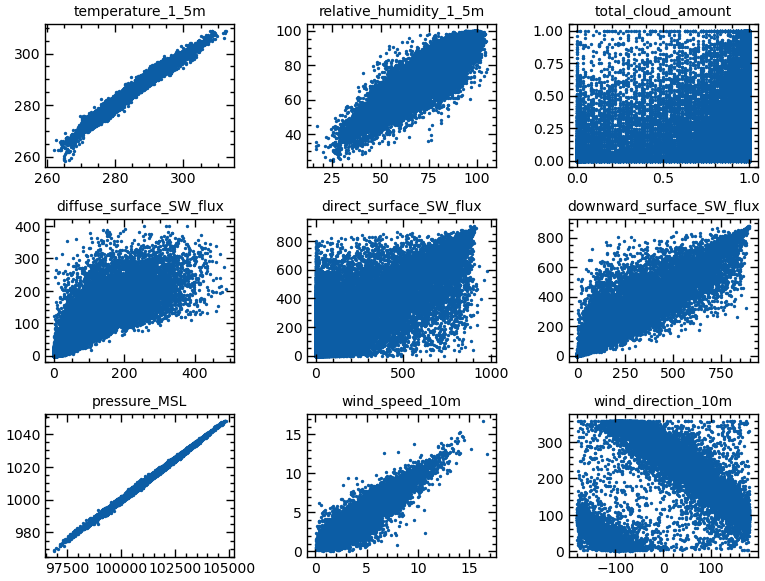

In [48]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].scatter(ceda[var], openmeteo[var],s=2)
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

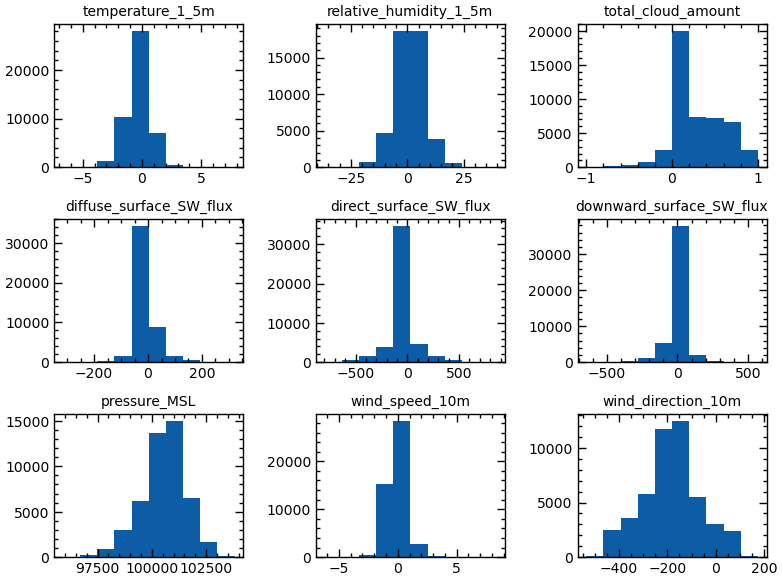

In [49]:
fig, axs = plt.subplots(rows, rows)
plt.tight_layout()
for i, var in enumerate(variates):
    x = i // rows
    y = i % rows
    axs[x,y].hist(ceda[var]-openmeteo[var])
    axs[x,y].set_title(var, fontsize = 10)
    axs[x,y].tick_params(labelsize=10)
plt.show()

## PROD_NL VS PVGIS

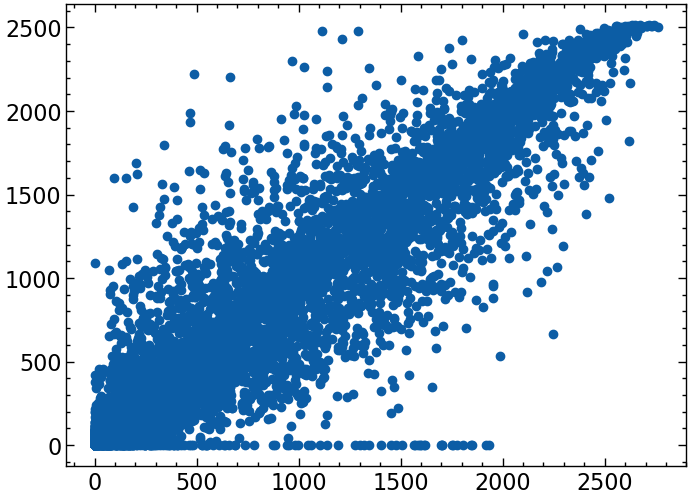

In [53]:
powers= pd.merge(pvgis, prod_NL, left_index=True, right_index=True)
plt.scatter(powers['P_x'], powers['P_y'])